In [1]:
import pandas as pd
import requests
import os
import sys
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import tweepy
import types

# 收集

In [2]:
# twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv','r', encoding = False)
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', encoding = "iso-8859-1")
# twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', sep=r'(?:,|\s+)', engine='python')

In [5]:
# 获取文件推特图片预测 image_predictions
## 1.确定image_predictions 的下载网址链接
image_predictions_url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
## 2.下载和保存文件
response = requests.get(image_predictions_url)
with open('image_predictions.csv', mode = 'wb') as file:
    file.write(response.content)
image_predictions = pd.read_csv('image_predictions.csv', sep = '\t')

In [6]:
# 获取文件3 每条推特的数据
# 直接读取项目提供的tweet_json.txt
tweet_json = pd.read_json('tweet_json.txt',lines = True)

## 从tweet_json中提取三个关键列'id','retweet_count','favorite_count',根据这三个指标建立tweet_keys，方便之后的评价分析。
tweet_info_keys = ['id','retweet_count','favorite_count']
tweet_keys = pd.DataFrame(tweet_json, columns=tweet_info_keys)

In [ ]:
'''
# 利用tweepy来获取。本项目采用直接读取已经提供的tweet_json.txt，如上。
# 将tweet_id存为list
# tweet_ID = np.array(str(twitter_archive_enhanced.tweet_id))
tweet_ID = np.array(twitter_archive_enhanced.tweet_id)
tweet_ID_list = tweet_ID.tolist()

# print(type(tweet_ID_list))

# 利用tweepy 创建tweet_json,并保存为tweet_json.txt
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

# 创建认证对象
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# 设置你的access token和access secret
auth.set_access_token(access_token, access_secret)
# 传入auth参数，创建API对象
# api = tweepy.API(auth, proxy = "127.0.0.1:1080"，wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
id_of_tweet = []
tweet = []

for id_of_tweet in tweet_ID_list:
    try:
        tweet_new = api.get_status(id_of_tweet, tweet_mode='extended')     
        #tweet_new = api.get_status(str(id_of_tweet), tweet_mode='extended')
        tweetid = tweet_new.id
        retweet_count = tweet_new.retweet_count
        favorite_count = tweet_new.favorite_count
        tweet.append({'id': tweetid, 
                      'retweet_count': retweet_count, 
                      'favorite_count': favorite_count})
    except Exception as e:
        # 输出错误信息
        print(str(tweetid) + ": " + str(e))

tweet_json = pd.DataFrame(tweet, columns = ['id', 'retweet_count', 'favorite_count']) 
tweet_json.to_csv('tweet_json_tweepy.txt')

# 三个关键列'id','retweet_count','favorite_count',根据这三个指标建立tweet_keys，方便之后的评价分析。
tweet_info_keys = ['id','retweet_count','favorite_count']
tweet_keys = pd.DataFrame(tweet_json, columns=tweet_info_keys)

'''

# 评估

##### 质量
###### `WeRateDogs 推特档案(twitter_archive_enhanced)`的评估
- timestamp, retweeted_status_timestamp 应当调整为时间序列
- tweet_id 应当为字符串str
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 采用 fillna 来将其转化为int
- rating_numerator分数最大值为1776，不合理
- rating_denominator分数最大值为170，不合理，这些评级通常以 10 作为分母
- tweet_id‘832215909146226688’的rating_numerator应当为9.75，而不是75
- name为'a', 'an', 'the'都是原始数据中缺失值，应当替换replace为'None'
- 转发的推相当于对于某条狗的重复评价，应当删除该行数据。

###### `image_predictions` 的评估
- tweet_id 应当为字符串str

###### `tweet_json` 的评估
- 有效性：in_reply_to_status_id、in_reply_to_user_id、retweeted_status_id、retweeted_status_user_id 应当为字符串str


##### 整洁度
###### `WeRateDogs 推特档案(twitter_archive_enhanced)`的评估
- tweet_json中的转发数（retweet_count）和喜欢数（favorite_count）应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
- 神经网络推测出的狗的品种 (或其他物体、动物等），即可信度最高的image_predictions中的p1，应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
`twitter_archive_enhanced 的评估`

In [7]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [57]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [74]:
# 验证是否有重复项,结果为没有
twitter_archive_enhanced['tweet_id'].duplicated().sum()

0

In [44]:
# 完整度
twitter_archive_enhanced[twitter_archive_enhanced['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [6]:
# 查找出 转发的tweet。
twitter_archive_enhanced[twitter_archive_enhanced['retweeted_status_id'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 19 to 2260
Data columns (total 17 columns):
tweet_id                      181 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     181 non-null object
source                        181 non-null object
text                          181 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 180 non-null object
rating_numerator              181 non-null int64
rating_denominator            181 non-null int64
name                          181 non-null object
doggo                         181 non-null object
floofer                       181 non-null object
pupper                        181 non-null object
puppo                         181 non-null object
dtypes: float64(4), int64(3), object(10)
memor

In [87]:
# 找出狗名字的重复数据
twitter_archive_enhanced[twitter_archive_enhanced['name'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [93]:
# name为'a', 'an', 'the'都是原始数据中缺失值，因为并没有狗的名字会叫做冠词。
twitter_archive_enhanced['name'].value_counts()

None           745
a               55
Charlie         12
Lucy            11
Oliver          11
Cooper          11
Penny           10
Lola            10
Tucker          10
Winston          9
Bo               9
the              8
Sadie            8
Daisy            7
Bailey           7
Buddy            7
Toby             7
an               7
Bella            6
Rusty            6
Leo              6
Koda             6
Scout            6
Jack             6
Jax              6
Milo             6
Oscar            6
Stanley          6
Dave             6
very             5
              ... 
Pherb            1
Lilli            1
Mark             1
Ricky            1
Toffee           1
Harlso           1
Vinnie           1
Sunshine         1
Vinscent         1
Rodney           1
Nida             1
Tassy            1
Tater            1
this             1
Coleman          1
Kobe             1
Oddie            1
Clarq            1
Binky            1
Einstein         1
Sobe             1
Edmund      

In [162]:
# rating_numerator的统计
twitter_archive_enhanced['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [163]:
# rating_denominator的统计
# 评级通常以 10 作为分母。
twitter_archive_enhanced['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

`image_predictions 的评估`

In [49]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [56]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [84]:
# 每条推的照片数量，结果发现最多4张，最少1张
image_predictions['img_num'].sort_values()

In [73]:
# 验证是否有重复项，结果为没有重复
image_predictions['tweet_id'].duplicated().sum()

0

`tweet_json 的评估`

In [5]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2351
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2352 non-null datetime64[ns]
display_text_range               2352 non-null object
entities                         2352 non-null object
extended_entities                2073 non-null object
favorite_count                   2352 non-null int64
favorited                        2352 non-null bool
full_text                        2352 non-null object
geo                              0 non-null float64
id                               2352 non-null int64
id_str                           2352 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [14]:
tweet_keys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
id                2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [69]:
tweet_keys.sample(10)

,id,retweet_count,favorite_count
1320,706169069255446529,2497,4269
44,883482846933004288,10336,46741
1357,703079050210877440,3480,8044
1549,688908934925697024,869,2304
1693,681231109724700672,539,2616
1452,695314793360662529,1664,3991
492,813172488309972993,2227,10344
2337,666094000022159362,78,168
1748,678969228704284672,527,1788
1530,689993469801164801,516,1610


In [22]:
tweet_keys.describe()

In [72]:
# 验证是否有重复项，结果为没有重复
tweet_keys['id'].duplicated().sum()

0

In [20]:
tweet_json.describe()

In [21]:
# 查看tweet.json数据
tweet_json.sample(5)

In [110]:
# 完整度
tweet_json[tweet_json['extended_entities'].isnull()]

In [11]:
# tweet_json['truncated'].duplicated()
# tweet_json['truncated'].duplicated().sum()
tweet_json['user']

# 清理

### 保存原始数据的副本

In [7]:
twitter_archive_enhanced_clean = twitter_archive_enhanced.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()
tweet_keys_clean = tweet_keys.copy()

### 整洁度
#### tweet_json中的转发数（retweet_count）和喜欢数（favorite_count）应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
##### 定义
将tweet_json中的retweet_count 和favorite_count导入一个 DataFrame 中，并它通过tweet_id拼接到 twitter_archive_enhanced_clean中。

##### 代码

In [8]:
# tweet_keys_clean中的d列改名为tweet_id后，twitter_archive_enhanced_clean就可以和tweet_keys_clean拼接。
tweet_keys_clean.rename(columns={'id':'tweet_id'}, inplace = True)

# 拼接
twitter_archive_enhanced_clean = pd.merge(twitter_archive_enhanced_clean, tweet_keys_clean, on='tweet_id', how='left')

##### 测试

In [122]:
tweet_keys_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null object
retweet_count     2356 non-null object
favorite_count    2356 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


In [123]:
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['retweet_count'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None,NaN,NaN
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None,NaN,NaN
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None,NaN,NaN
132,866816280283807744,NaN,NaN,2017-05-23 00:41:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Jamesy. He gives a kiss...,8.664507e+17,4.196984e+09,2017-05-22 00:28:40 +0000,https://twitter.com/dog_rates/status/866450705...,13,10,Jamesy,None,None,pupper,None,NaN,NaN
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None,None,None,NaN,NaN
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,https://twitter.com/dog_rates/status/756288534...,12,10,None,None,None,None,None,NaN,NaN
260,842892208864923648,NaN,NaN,2017-03-18 00:15:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,8.071068e+17,4.196984e+09,2016-12-09 06:17:20 +0000,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None,NaN,NaN
298,837012587749474308,NaN,NaN,2017-03-01 18:52:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KennyFromDaBlok: 14/10 h*ckin good hats. w...,8.370113e+17,7.266347e+08,2017-03-01 18:47:10 +0000,https://twitter.com/KennyFromDaBlok/status/837...,14,10,None,None,None,None,None,NaN,NaN
382,827228250799742977,NaN,NaN,2017-02-02 18:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Phil. He's an important...,6.946697e+17,4.196984e+09,2016-02-02 23:52:22 +0000,https://twitter.com/dog_rates/status/694669722...,12,10,Phil,None,None,None,None,NaN,NaN
566,802247111496568832,NaN,NaN,2016-11-25 20:26:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,7.790561e+17,4.196984e+09,2016-09-22 20:33:42 +0000,https://twitter.com/dog_rates/status/779056095...,13,10,None,None,None,None,None,NaN,NaN


In [124]:
# 可发现retweet_count 和favorite_count的index已经加入twitter_archive_enhanced_clean中
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 2

#### image_predictions中的p1，应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
##### 定义
通过 image_predictions 中的tweet_id，将其中的p1拼接到twitter_archive_enhanced_clean中。
##### 代码

In [9]:
twitter_archive_enhanced_clean = pd.merge(twitter_archive_enhanced_clean, image_predictions, on='tweet_id', how='left')

##### 测试

In [126]:
# 可发现p1,p1_conf和p1_dog已经加入twitter_archive_enhanced_clean中
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 2

### 质量
#### `twitter_archive_enhanced`中name为'a', 'an', 'the'都是原始数据中缺失值，替换为'None'
##### 定义
使用函数，将 a, an, the 转变为 None。

##### 代码

In [10]:
# name的映射
a_clean = {'a': 'None', 'an': 'None', 'the': 'None'}
# 替换名字函数
def replace_name(twitter_archive_enhanced):
    if twitter_archive_enhanced['name'] in a_clean.keys():
        clean_name = a_clean[twitter_archive_enhanced['name']]
        return clean_name
    else:
        return twitter_archive_enhanced['name']

twitter_archive_enhanced_clean['name'] = twitter_archive_enhanced_clean.apply(replace_name, axis=1)

##### 测试

In [128]:
# 'name'为'a', 'an', 'the'均已经替换为'None'
twitter_archive_enhanced_clean['name'].value_counts()

None        815
Charlie      12
Cooper       11
Oliver       11
Lucy         11
Lola         10
Tucker       10
Penny        10
Winston       9
Bo            9
Sadie         8
Bailey        7
Daisy         7
Buddy         7
Toby          7
Milo          6
Bella         6
Jack          6
Leo           6
Stanley       6
Rusty         6
Oscar         6
Scout         6
Dave          6
Jax           6
Koda          6
Oakley        5
Sammy         5
Alfie         5
Chester       5
           ... 
Lucia         1
Rufio         1
Lilah         1
Bauer         1
Franq         1
Jeffrie       1
Alf           1
Berkeley      1
Ferg          1
Kane          1
Trip          1
Stella        1
Shiloh        1
Eevee         1
Jerome        1
Sweet         1
Eleanor       1
Tassy         1
Vixen         1
Kollin        1
Harlso        1
Beckham       1
Eugene        1
Beebop        1
Bradlay       1
Emmie         1
Toffee        1
Jessifer      1
Jo            1
Mo            1
Name: name, Length: 954,

#### 错误的数据类型
##### 定义
- timestamp, retweeted_status_timestamp 中均有‘ +0000’ 的后缀，应当删除，并转化为 datetime 数据类型。
- tweet_id 应当为字符串str
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 采用 fillna 来将其转化为int

##### 代码

In [11]:
# 删除timestamp的‘ +0000’ 的后缀
twitter_archive_enhanced_clean.timestamp = twitter_archive_enhanced_clean.timestamp.str.strip('\s\+0000')
twitter_archive_enhanced_clean.retweeted_status_timestamp = twitter_archive_enhanced_clean.retweeted_status_timestamp.str.strip('\s\+0000')
# 将timestamp转化为 datetime 类型
twitter_archive_enhanced_clean.timestamp = pd.to_datetime(twitter_archive_enhanced_clean.timestamp)
twitter_archive_enhanced_clean.retweeted_status_timestamp = pd.to_datetime(twitter_archive_enhanced_clean.retweeted_status_timestamp)

In [12]:
# 将tweet_id转为str数据类型
twitter_archive_enhanced_clean.tweet_id = twitter_archive_enhanced_clean.tweet_id.astype('str')
# 回复、转发相关id和转发相关id为float64，且存在NaN，则采用 .fillna() 来将其转化为int
# 参考 https://stackoverflow.com/questions/47013973/pandas-converts-float64-to-int
twitter_archive_enhanced_clean.in_reply_to_status_id = twitter_archive_enhanced_clean.in_reply_to_status_id.fillna(0).astype(np.int64)
twitter_archive_enhanced_clean.in_reply_to_user_id = twitter_archive_enhanced_clean.in_reply_to_user_id.fillna(0).astype(np.int64)
twitter_archive_enhanced_clean.retweeted_status_id = twitter_archive_enhanced_clean.retweeted_status_id.fillna(0).astype(np.int64)
twitter_archive_enhanced_clean.retweeted_status_user_id = twitter_archive_enhanced_clean.retweeted_status_user_id.fillna(0).astype(np.int64)

# 回复、转发相关id和转发相关id为float64，且存在NaN，则采用 .fillna() 来将其转化为int
# 参考 https://stackoverflow.com/questions/47013973/pandas-converts-float64-to-int
twitter_archive_enhanced_clean.retweet_count = twitter_archive_enhanced_clean.retweet_count.fillna(0).astype(np.float)
twitter_archive_enhanced_clean.favorite_count = twitter_archive_enhanced_clean.favorite_count.fillna(0).astype(np.float)

##### 测试

In [68]:
# 测试timestamp, retweeted_status_timestamp 中‘ +0000’ 的后缀是否已经删除，并转化为 datetime 数据类型。
twitter_archive_enhanced_clean.sample(10)

In [132]:
# 查看 数据类型是否转化为 datetime, str, float和 int 类型
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null int64
in_reply_to_user_id           2356 non-null int64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null int64
retweeted_status_user_id      2356 non-null int64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 235

#### `twitter_archive_enhanced`中 tweet_id 为 ‘832215909146226688’ 的rating_numerator应当为9.75，而不是75。
##### 定义

把tweet_id 为'832215909146226688'的行隔离出来，并把rating_numerator修改为9.75。

##### 代码

In [13]:
mask = twitter_archive_enhanced_clean['tweet_id'] == '832215909146226688'
column_name = 'rating_numerator'
twitter_archive_enhanced_clean.loc[mask,column_name] = 9.75

##### 测试

In [21]:
# tweet_id 为 ‘832215909146226688’ 的rating_numerator已经改为9.75。
twitter_archive_enhanced_clean.loc[mask,column_name]

340    9.75
Name: rating_numerator, dtype: float64

#### 转发的推相当于对于该狗的重复评价，应当删除该行狗的数据。
##### 定义
- 转发的tweet应当删除，找出带有retweeted_status_id的行，然后去除该行
##### 代码

In [134]:
# retweeted_status_id为0的推文是没有转发的。
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[np.abs(twitter_archive_enhanced_clean['retweeted_status_id']) == 0]

##### 测试

In [63]:
# retweeted_status_id，retweeted_status_user_id，retweeted_status_timestamp这三列的值已经均为NaN。
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null int64
in_reply_to_user_id           2175 non-null int64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null int64
retweeted_status_user_id      2175 non-null int64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
retweet_count      

In [64]:
# 原来19行 tweet_id为888202515573088257的推文，是转发推文，已经被去除了。
twitter_archive_enhanced_clean.head(30)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,0,0,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,0,0,NaT,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,0,0,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,0,0,NaT,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,0,0,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,0,0,NaT,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,0,0,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,0,0,NaT,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,0,0,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,0,0,NaT,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,0,0,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,0,0,NaT,https://twitter.com/dog_rates/status/891087950...,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,0,0,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,0,0,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,0,0,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,0,0,NaT,https://twitter.com/dog_rates/status/890729181...,...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,0,0,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,0,0,NaT,https://twitter.com/dog_rates/status/890609185...,...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,0,0,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,0,0,NaT,https://twitter.com/dog_rates/status/890240255...,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


#### 原始数据不合理
##### 定义
- rating_numerator分数最大值为1776，不合理。rating_denominator分数最大值为170，不合理，这些评级通常以 10 作为分母。
- 针对以上两个问题确定了新指标RATING，即每条狗的rating_numerator/rating_denominator的比值，并去除NaN值和非常大的奇异值（本项目认为大于2即为奇异值），RATING的高低可以有效体现每条狗的评级，分数越大，表明狗评级越高、越收到欢迎。之后的分析结论也是基于RATING一列。

##### 代码

In [40]:
# rating_numerator_morethan20 = twitter_archive_enhanced_clean[(np.abs(twitter_archive_enhanced_clean.rating_numerator) >= 20)]
# rating_numerator_morethan20

In [14]:
# 定义 RATING
twitter_archive_enhanced_clean['RATING'] = twitter_archive_enhanced_clean['rating_numerator']/twitter_archive_enhanced_clean['rating_denominator']
# 去除 twitter_archive_enhanced_clean['RATING'] 中的NaN值和非常大的奇异值（本项目认为大于20即为奇异值）
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[np.abs(twitter_archive_enhanced_clean['RATING']) <= 2]

##### 测试

In [95]:
twitter_archive_enhanced_clean.sample(30)

In [70]:
# 查看是否还存在奇异值和NaN。
twitter_archive_enhanced_clean['RATING'].value_counts()

1.200000    504
1.000000    444
1.100000    431
1.300000    307
0.900000    156
0.800000     98
0.700000     53
1.400000     43
0.500000     37
0.600000     32
0.300000     19
0.400000     15
0.200000     11
0.100000      7
0.000000      2
0.818182      1
1.700000      1
0.733333      1
0.636364      1
1.250000      1
1.500000      1
Name: RATING, dtype: int64

In [136]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2165 non-null object
in_reply_to_status_id         2165 non-null int64
in_reply_to_user_id           2165 non-null int64
timestamp                     2165 non-null object
source                        2165 non-null object
text                          2165 non-null object
retweeted_status_id           2165 non-null int64
retweeted_status_user_id      2165 non-null int64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2111 non-null object
rating_numerator              2165 non-null float64
rating_denominator            2165 non-null int64
name                          2165 non-null object
doggo                         2165 non-null object
floofer                       2165 non-null object
pupper                        2165 non-null object
puppo                         2165 non-null object
retweet_count                 216

# 分析、结论

### 1. 评级最高的Top_3 狗的品种

找出评级（RATING）前三的狗的品种（p1）

#### 代码

In [15]:
# p1_dog为True的推文中提到的才是狗。所以建立 twitter_archive_enhanced_clean_p1，整理出为狗的数据。
# 首先将 .p1_dog转化为bool值
twitter_archive_enhanced_clean.p1_dog = twitter_archive_enhanced_clean.p1_dog.astype(np.bool)
# twitter_archive_enhanced_clean_p1就是推文图片中是狗的数据
twitter_archive_enhanced_clean_p1 = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.p1_dog == True]
# p1_Rating为每种狗的评级均值
p1_Rating = twitter_archive_enhanced_clean_p1['RATING'].groupby(twitter_archive_enhanced_clean_p1['p1']).mean()
# 对每种狗评级均值的排名。本项目提取出前10名。
p1_Rating.sort_values(ascending = False).head(10)

p1
Saluki                1.250000
Tibetan_mastiff       1.240000
briard                1.233333
Border_terrier        1.214286
standard_schnauzer    1.200000
silky_terrier         1.200000
giant_schnauzer       1.200000
Irish_setter          1.183333
Eskimo_dog            1.177778
Gordon_setter         1.175000
Name: RATING, dtype: float64

In [19]:
# 推文图片中是狗的情况下，被提及最多的狗的品种统计情况，其中Top3为golden_retriever，Labrador_retriever，Pembroke
twitter_archive_enhanced_clean_p1.p1.value_counts()

golden_retriever               149
Labrador_retriever             100
Pembroke                        89
Chihuahua                       83
pug                             57
chow                            44
Samoyed                         43
toy_poodle                      39
Pomeranian                      37
malamute                        30
cocker_spaniel                  30
French_bulldog                  26
Chesapeake_Bay_retriever        23
miniature_pinscher              23
German_shepherd                 20
Staffordshire_bullterrier       20
Siberian_husky                  20
Cardigan                        19
beagle                          18
Shetland_sheepdog               18
Eskimo_dog                      18
Maltese_dog                     18
Rottweiler                      17
Lakeland_terrier                17
Shih-Tzu                        17
Italian_greyhound               16
kuvasz                          15
Great_Pyrenees                  14
West_Highland_white_

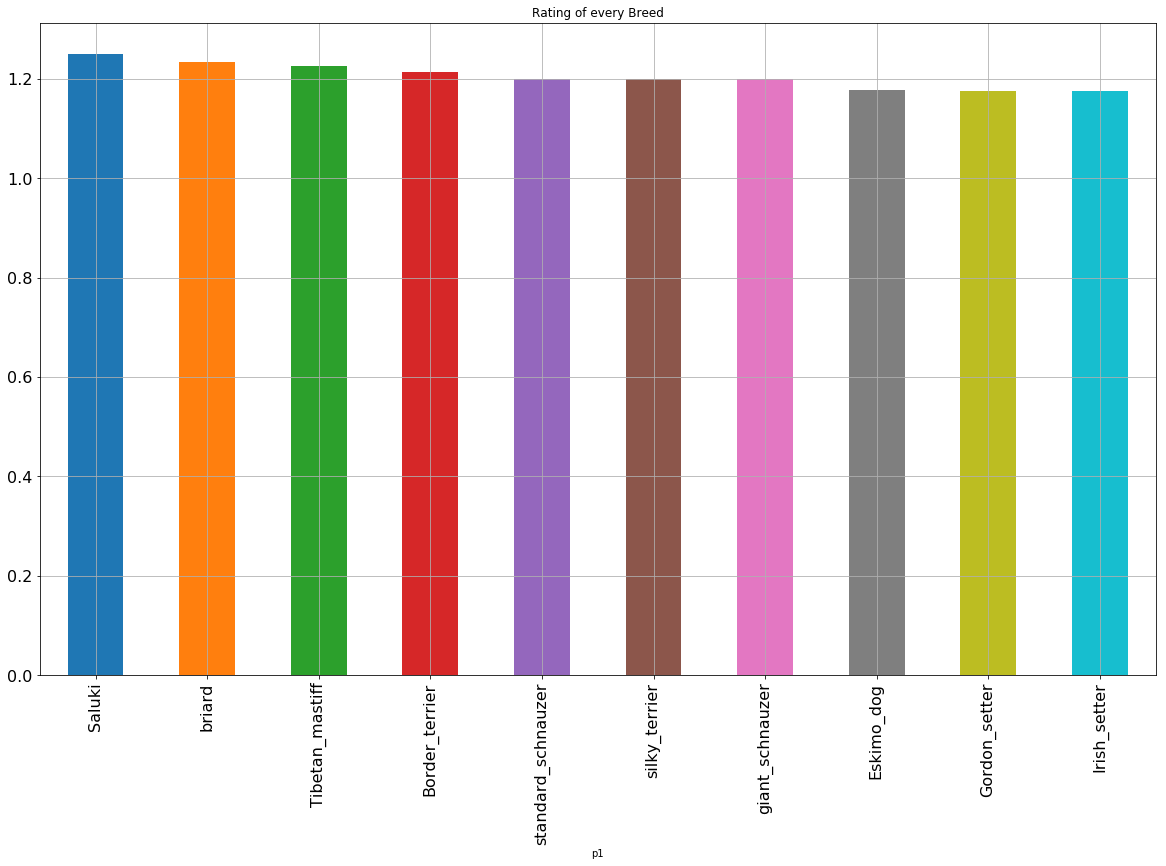

In [138]:
# 评级均值前10名的狗的品种柱状图绘制
p1_Rating.sort_values(ascending = False).head(10).plot(kind='bar',title='Rating of every Breed',figsize=(20, 12),fontsize=16,grid = True)

#### 分析和结论
1. 由计算结果和柱状图可知，Top5的狗的品种为 **Saluki，briard，Tibetan_mastiff，Border_terrier，standard_schnauzer**。
2. 推文图片中是狗的情况下，被提及最多的狗的品种统计情况，其中Top3为 **golden_retriever，Labrador_retriever，Pembroke**。这三种狗可能也是最为常见的。

### 2. 推文中狗的评级和转发量、点赞量的相关性

通过计算推文中狗的评级和转发量、点赞量之间的相关系数，分析它们之间的相关性。

#### 代码

In [139]:
twitter_archive_enhanced_clean_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 1 to 2355
Data columns (total 31 columns):
tweet_id                      1650 non-null object
in_reply_to_status_id         1650 non-null int64
in_reply_to_user_id           1650 non-null int64
timestamp                     1650 non-null object
source                        1650 non-null object
text                          1650 non-null object
retweeted_status_id           1650 non-null int64
retweeted_status_user_id      1650 non-null int64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1596 non-null object
rating_numerator              1650 non-null float64
rating_denominator            1650 non-null int64
name                          1650 non-null object
doggo                         1650 non-null object
floofer                       1650 non-null object
pupper                        1650 non-null object
puppo                         1650 non-null object
retweet_count                 165

In [140]:
# 推文中对象为狗时，评级和转发量的相关系数
twitter_archive_enhanced_clean_p1.RATING.corr(twitter_archive_enhanced_clean_p1.retweet_count)

0.30408450998155173

In [141]:
# 推文中对象为狗时，评级和点赞量的相关系数
twitter_archive_enhanced_clean_p1.RATING.corr(twitter_archive_enhanced_clean_p1.favorite_count)

0.39312787526713011

#### 分析和结论

* 相关系数均为正数，所以评级和转发量（或点赞量）为正相关性，当评级较高时，转发量和点赞量也会增加。
* 0.30和0.39较为接近，所以评级与转发量的变化过程、评级和点赞量的变化过程，这两种变化过程有着较高的相似度。

### 3. 如果推文中提到的对象不是狗，是否会影响转发量、点赞量和评级

通过分析1已经分析了推文中对象为狗时的转发量和点赞量，并得到了相关系数。有了这个这基础，我们只要关注在推文中没有狗时，转发量、点赞量和评级均值是否会减少，相关性会发生什么变化。

#### 代码

In [142]:
# p1_dog为False的推文中提到的就不是狗。所以建立 twitter_archive_enhanced_clean_p1_NotDog，汇总不是狗的数据。
twitter_archive_enhanced_clean_p1_NotDog = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.p1_dog == False]

In [114]:
twitter_archive_enhanced_clean_p1_NotDog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 0 to 2349
Data columns (total 31 columns):
tweet_id                      515 non-null object
in_reply_to_status_id         515 non-null int64
in_reply_to_user_id           515 non-null int64
timestamp                     515 non-null datetime64[ns]
source                        515 non-null object
text                          515 non-null object
retweeted_status_id           515 non-null int64
retweeted_status_user_id      515 non-null int64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 515 non-null object
rating_numerator              515 non-null float64
rating_denominator            515 non-null int64
name                          515 non-null object
doggo                         515 non-null object
floofer                       515 non-null object
pupper                        515 non-null object
puppo                         515 non-null object
retweet_count                 514 

In [143]:
twitter_archive_enhanced_clean_p1_NotDog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 0 to 2349
Data columns (total 31 columns):
tweet_id                      515 non-null object
in_reply_to_status_id         515 non-null int64
in_reply_to_user_id           515 non-null int64
timestamp                     515 non-null object
source                        515 non-null object
text                          515 non-null object
retweeted_status_id           515 non-null int64
retweeted_status_user_id      515 non-null int64
retweeted_status_timestamp    0 non-null object
expanded_urls                 515 non-null object
rating_numerator              515 non-null float64
rating_denominator            515 non-null int64
name                          515 non-null object
doggo                         515 non-null object
floofer                       515 non-null object
pupper                        515 non-null object
puppo                         515 non-null object
retweet_count                 515 non-null float64

In [144]:
# 分析推文对象不是狗的数据
twitter_archive_enhanced_clean_p1_NotDog.describe()
# 由此可知，当推文中不是狗时，推文转发量均值为2694.2，点赞量均值为7879.2，对象评级均值为0.949.

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf,RATING
count,5.150000e+02,5.150000e+02,515.0,515.0,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,5.150000e+02,5.150000e+02,515.000000
mean,1.226892e+16,7.334535e+07,0.0,0.0,10.116505,10.526214,2694.198058,7879.221359,1.172816,0.536453,1.159491e-01,5.631393e-02,0.948614
std,9.218627e+16,5.504890e+08,0.0,0.0,10.818183,8.548147,4566.852398,11720.838984,0.517438,0.295196,9.318454e-02,4.559812e-02,0.294113
min,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,10.000000,0.000000,0.000000,1.000000,0.059033,1.011300e-08,1.740170e-10,0.000000
25%,0.000000e+00,0.000000e+00,0.0,0.0,8.000000,10.000000,568.500000,1480.000000,1.000000,0.276592,4.617995e-02,1.833315e-02,0.800000
50%,0.000000e+00,0.000000e+00,0.0,0.0,10.000000,10.000000,1104.000000,3116.000000,1.000000,0.478616,9.914020e-02,4.917630e-02,1.000000
75%,0.000000e+00,0.000000e+00,0.0,0.0,12.000000,10.000000,2819.500000,9337.000000,1.000000,0.821904,1.602395e-01,8.308555e-02,1.200000
max,7.590995e+17,4.196984e+09,0.0,0.0,204.000000,170.000000,39825.000000,93032.000000,4.000000,1.000000,4.880140e-01,2.551820e-01,1.400000


In [145]:
# 分析推文对象是狗的数据
twitter_archive_enhanced_clean_p1.describe()
# 由此可知，当推文中是狗时，推文转发量均值为2745.1，比不是狗的推文的转发量增加了1.9%；推文中是狗时的点赞量均值为9027.3，比不是狗的推文的转发量增加了14.6%；推文中是狗时的评级均值为1.096，比不是狗的推文的转发量增加了15.5%.

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf,RATING
count,1.650000e+03,1.650000e+03,1650.0,1650.0,1650.000000,1650.000000,1650.000000,1650.000000,1473.000000,1473.000000,1473.000000,1.473000e+03,1650.000000
mean,2.936122e+16,9.521534e+14,0.0,0.0,11.489091,10.493333,2745.112121,9027.338788,1.214528,0.614183,0.141111,6.165841e-02,1.096062
std,1.458138e+17,2.740729e+16,0.0,0.0,7.310671,6.488523,4749.108243,12677.110055,0.575903,0.260397,0.102511,5.262158e-02,0.179296
min,0.000000e+00,0.000000e+00,0.0,0.0,1.000000,2.000000,0.000000,51.000000,1.000000,0.044333,0.000023,2.160900e-07,0.100000
25%,0.000000e+00,0.000000e+00,0.0,0.0,10.000000,10.000000,604.500000,2060.500000,1.000000,0.391471,0.057091,1.524340e-02,1.000000
50%,0.000000e+00,0.000000e+00,0.0,0.0,11.000000,10.000000,1383.500000,4253.500000,1.000000,0.615741,0.126758,4.981050e-02,1.100000
75%,0.000000e+00,0.000000e+00,0.0,0.0,12.000000,10.000000,3182.500000,11291.000000,1.000000,0.852088,0.203671,9.499060e-02,1.200000
max,8.862664e+17,8.405479e+17,0.0,0.0,165.000000,150.000000,77979.000000,144133.000000,4.000000,0.999956,0.467678,2.734190e-01,1.700000


In [146]:
# 推文中对象不是狗时，评级和转发量的相关系数
twitter_archive_enhanced_clean_p1_NotDog.RATING.corr(twitter_archive_enhanced_clean_p1_NotDog.retweet_count)

0.30840637508778407

In [147]:
# 推文中对象不是狗时，评级和点赞量的相关系数
twitter_archive_enhanced_clean_p1_NotDog.RATING.corr(twitter_archive_enhanced_clean_p1_NotDog.favorite_count)

0.38711747688498033

#### 分析和结论

* 相关系数均为正数，相关系数也较为接近，这两点和推文中为狗时情况一样。
* 推文为狗时两个相关系数为0.31和0.39，推文不为狗时的系数为0.31和0.39，与前者非常接近。推文评级和转发量的变化过程，评级和点赞量的变化过程，与推文对象是否为狗没有关系，变化过程也非常相似。
* 当对象是狗的推文相比不是狗的推文，转发量均值变化很小，点赞量均值和评级均值会有15%左右的变化。

# 数据输出

将合并清洗后数据写出到twitter_archive_master.csv

#### 代码

In [148]:
twitter_archive_enhanced_clean.to_csv('twitter_archive_master.csv')